In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import tensorflow.keras as keras
from tensorflow.keras import applications
from tensorflow.keras.layers import Flatten, LeakyReLU, Dense
from tensorflow.keras.models import *
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import random
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf


from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

from os import listdir
from os.path import isfile, join

# training data
image_size = 224
labels = pd.read_csv("data/fgvc7/train.csv")
image_dir = "data/fgvc7/images"

In [2]:
# import image data and combine labels
def load_data(dataset='Train',image_dir= 'data/fgvc7/images'):
    X = []
    y = []
    for f in listdir(image_dir):
        if isfile(join(image_dir, f)) and f[:len(dataset)]==dataset:
            # add filename
            #train_list.append(f)
            # add image to the list
            img = load_img(f'{image_dir}/{f}', target_size=(image_size,image_size,3))
            img_array = img_to_array(img, dtype='uint8')
            # Get id
            id = int(f[len(dataset)+1:-4])
            X.append(img_array)
            if dataset=='Train':
                y.append(labels.iloc[id][['healthy', 'multiple_diseases', 'rust', 'scab']].to_numpy())
            else:
                y.append([f[:-4], id])
    if dataset=='Train':
        y = np.array(y, dtype=np.uint16)   
    return np.array(X, dtype=np.uint16), y

In [3]:
# import training data and combine labels
data_x, data_y  = load_data() 

## Augmentation

In [4]:
import imgaug.augmenters as iaa
seq = iaa.Sequential([
    iaa.SomeOf((0,2),[
        iaa.Identity(),
        iaa.AverageBlur(k=((3, 5), (5, 7))),
        iaa.Rotate((-45,45)),
        iaa.Affine(scale=(0.5, 0.95)),    
        iaa.Multiply((0.50, 1.1))
        #,iaa.BlendAlphaRegularGrid(nb_rows=(4, 6), nb_cols=(1, 4),
        #                        foreground=iaa.Multiply(0.0))
        #,iaa.Cartoon()
        ,iaa.Cutout(nb_iterations=(1, 3), size=0.2, squared=False, cval=0)
        ,iaa.Affine(shear=(-48, 48))
        ,iaa.Affine(translate_px={"x": (-42, 42), "y": (-36, 36)})
        ,iaa.KeepSizeByResize(iaa.Resize({"height": (0.70, 0.90), "width": (0.70, 0.90)}))
        ,iaa.CropAndPad(percent=(-0.2, 0.2))
        #,iaa.PiecewiseAffine(scale=(0.01, 0.05))
        ,iaa.PerspectiveTransform(scale=(0.01, 0.1))
        #,iaa.WithPolarWarping(iaa.CropAndPad(percent=(-0.1, 0.1)))
        #,iaa.ElasticTransformation(alpha=(0, 3.0), sigma=0.5)
       ])
    #,iaa.SaveDebugImageEveryNBatches(folder_path, 100)    
], random_order=True)


In [5]:
def generator(features, labels, batch_size):
    while True:
        # Fill arrays of batch size with augmented data taken randomly from full passed arrays
        indexes = random.sample(range(len(features)), batch_size)
      
        # Transform X and y
        x_aug = seq(images =features[indexes])
        yield np.array(x_aug), np.array(labels[indexes])

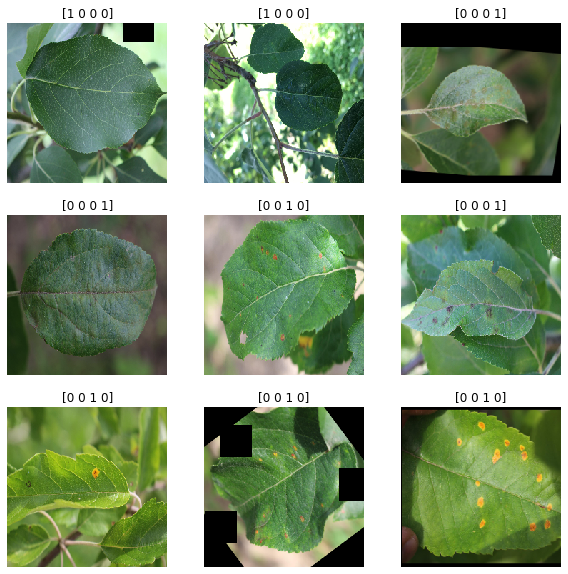

In [6]:
images = generator(data_x,data_y, 9)
image = next(images)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    #augmented_image = seq(images = x_train[:1])
    plt.imshow(image[0][i])
    plt.title(str(image[1][i]))
    plt.axis("off")

## Transfer Learning

In [7]:
x_train, x_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.20, random_state=42)
y_train = np.argmax(y_train,axis=1)
y_val = np.argmax(y_val,axis=1)

In [8]:
base_model = keras.applications.Xception(
    weights='imagenet',
    input_shape=(image_size, image_size, 3),
    include_top=False)

In [9]:
# Create new model on top.
inputs = keras.Input(shape=(image_size, image_size, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(4)(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
xception (Model)             (None, 7, 7, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 8196      
Total params: 20,869,676
Trainable params: 20,815,148
Non-trainable params: 54,528
_________________________________________________________________


In [10]:
# Warm up head
adam = optimizers.Adam(learning_rate=0.0005)
#lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                           factor=0.2,  
                           patience=3, 
                           min_lr=0.00005)
early_stop = EarlyStopping(
    monitor='val_loss', 
    min_delta=0, 
    patience=6, 
    verbose=0, 
    mode='auto',
    baseline=None, 
    restore_best_weights=True
)

batch_size = 64
#num_warmup_steps = 5

# freeze pretrained weights
model.layers[1].trainable = False

model.compile(optimizer=adam, 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalCrossentropy()])


history = model.fit(generator(x_train, y_train, batch_size),  
                    shuffle=True,  
                    validation_data = (x_val, y_val),
                    callbacks = [reduce_lr,early_stop],                        
                    epochs=100,
                    steps_per_epoch=len(x_train)/batch_size ,
                    verbose=True
                   )
print(model.optimizer.lr)

Epoch 1/100
23/22 [==============================] - 19s 814ms/step - loss: 3.4085 - sparse_categorical_crossentropy: 3.4085 - val_loss: 1.8077 - val_sparse_categorical_crossentropy: 1.8077 - lr: 5.0000e-04
Epoch 2/100
23/22 [==============================] - 16s 707ms/step - loss: 1.4829 - sparse_categorical_crossentropy: 1.4829 - val_loss: 1.4267 - val_sparse_categorical_crossentropy: 1.4267 - lr: 5.0000e-04
Epoch 3/100
23/22 [==============================] - 16s 714ms/step - loss: 1.4131 - sparse_categorical_crossentropy: 1.4131 - val_loss: 1.3863 - val_sparse_categorical_crossentropy: 1.3863 - lr: 5.0000e-04
Epoch 4/100
23/22 [==============================] - 16s 711ms/step - loss: 1.3844 - sparse_categorical_crossentropy: 1.3844 - val_loss: 1.3863 - val_sparse_categorical_crossentropy: 1.3863 - lr: 5.0000e-04
Epoch 5/100
23/22 [==============================] - 16s 715ms/step - loss: 1.3945 - sparse_categorical_crossentropy: 1.3945 - val_loss: 1.3863 - val_sparse_categorical_cro

In [11]:
# Train entire network
adam = optimizers.Adam(learning_rate=0.0001)
#lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                           factor=0.2,  
                           patience=5 , 
                           min_lr=0.00001)
early_stop = EarlyStopping(
    monitor='val_accuracy', 
    min_delta=0, 
    patience=10, 
    verbose=0, 
    mode='auto',
    baseline=None, 
    restore_best_weights=True
)

# freeze pretrained weights
model.layers[1].trainable = True

model.compile(optimizer=adam, 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history2 = model.fit(generator(x_train, y_train, batch_size),  
                    shuffle=True,  
                    validation_data = (x_val, y_val),
                    callbacks = [reduce_lr,early_stop],                        
                    epochs=200,
                    steps_per_epoch=len(x_train)/batch_size ,
                    verbose=True
                   )

Epoch 1/200
23/22 [==============================] - 56s 2s/step - loss: 2.2703 - accuracy: 0.2812 - val_loss: 1.3606 - val_accuracy: 0.3260 - lr: 1.0000e-04
Epoch 2/200
23/22 [==============================] - 55s 2s/step - loss: 1.3490 - accuracy: 0.2704 - val_loss: 1.2875 - val_accuracy: 0.3041 - lr: 1.0000e-04
Epoch 3/200
23/22 [==============================] - 56s 2s/step - loss: 1.2927 - accuracy: 0.2935 - val_loss: 1.2210 - val_accuracy: 0.3260 - lr: 1.0000e-04
Epoch 4/200
23/22 [==============================] - 56s 2s/step - loss: 1.2338 - accuracy: 0.3648 - val_loss: 1.2381 - val_accuracy: 0.3342 - lr: 1.0000e-04
Epoch 5/200
23/22 [==============================] - 56s 2s/step - loss: 1.2181 - accuracy: 0.3913 - val_loss: 1.1941 - val_accuracy: 0.4000 - lr: 1.0000e-04
Epoch 6/200
23/22 [==============================] - 56s 2s/step - loss: 1.2010 - accuracy: 0.4552 - val_loss: 1.1270 - val_accuracy: 0.4658 - lr: 1.0000e-04
Epoch 7/200
23/22 [==============================] -

In [12]:
model.save('models/xception')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: models/xception/assets


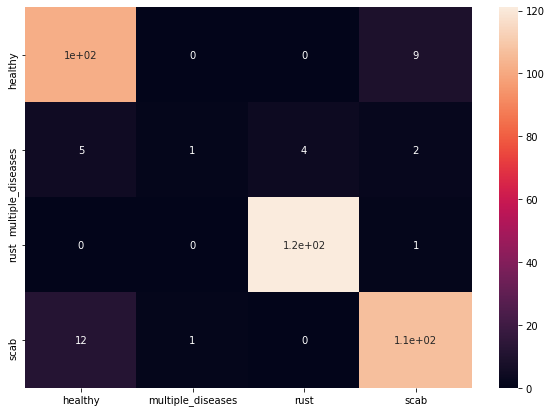

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

labels = ['healthy', 'multiple_diseases', 'rust', 'scab']
y_val_pred = np.argmax(model.predict(x_val), axis=1)
mat = confusion_matrix(y_val, y_val_pred)

df_cm = pd.DataFrame(mat, index = [i for i in labels],
                  columns = [i for i in labels])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

In [14]:
# Train on all data before inference
model.fit(generator(x_val, y_val, batch_size),            
                    epochs=2,
                    steps_per_epoch=len(x_train)/batch_size ,
                    verbose=True
                   )

Epoch 1/2
23/22 [==============================] - 52s 2s/step - loss: 0.3737 - accuracy: 0.8859
Epoch 2/2
23/22 [==============================] - 52s 2s/step - loss: 0.3477 - accuracy: 0.8743


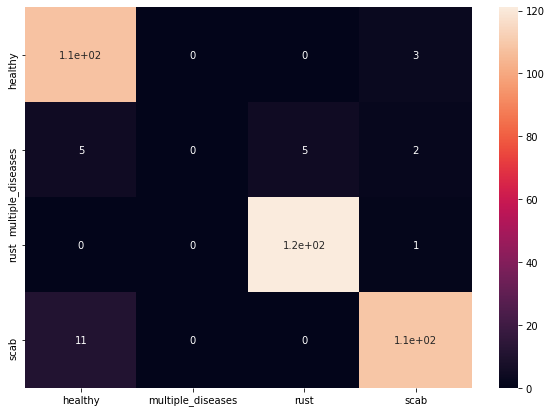

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

labels = ['healthy', 'multiple_diseases', 'rust', 'scab']
y_val_pred = np.argmax(model.predict(x_val), axis=1)
mat = confusion_matrix(y_val, y_val_pred)

df_cm = pd.DataFrame(mat, index = [i for i in labels],
                  columns = [i for i in labels])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

In [21]:
# Load test data and their filename for submission file
test_x, test_id  = load_data("Test") 
test_y = model.predict(test_x)
test_pred = tf.nn.softmax(test_y).numpy()
test_set = np.hstack((test_id, test_pred))
test_set = test_set[test_set[:,1].astype('uint16').argsort()]
test_DF = pd.DataFrame(test_set, index=test_set[:,1], columns=["image_id","id","healthy","multiple_diseases","rust","scab"])
test_DF[["image_id","healthy","multiple_diseases","rust","scab"]].to_csv('submissions/xception.csv', index=False)

In [22]:
!kaggle competitions submit -f 'submissions/xception.csv' -m"xception baseline 20210130" plant-pathology-2020-fgvc7

100%|█████████████████████████████████████████| 102k/102k [00:00<00:00, 235kB/s]
Successfully submitted to Plant Pathology 2020 - FGVC7

In [23]:
!kaggle competitions submissions plant-pathology-2020-fgvc7

fileName               date                 description                  status    publicScore  privateScore  
---------------------  -------------------  ---------------------------  --------  -----------  ------------  
xception.csv           2021-01-31 16:12:55  xception baseline 20210130   complete  0.88840      0.87141       
inceptionResNetv2.csv  2021-01-31 02:36:15  inception baseline 20210130  complete  0.92493      0.93380       


#### 0.9338 is #801 on leaderboard

## Convert to TFLite

In [24]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model("models/xception") # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('models/xception.tflite', 'wb') as f:
    f.write(tflite_model)

In [25]:
import cv2
for i in range(5):
    index = np.random.randint(len(x_train))
    print(f"====TF Model result{index}====")
    print(model.predict(np.expand_dims(x_train[index],axis=0)))
    print(y_train[index])

    interpreter = tf.lite.Interpreter(model_path="models/xception.tflite")
    interpreter.allocate_tensors()
    # Get input and output tensors.
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Test the model on random input data.
    input_shape = input_details[0]['shape']

    img = cv2.resize(x_train[index], (image_size,image_size)).astype('float32')

    input_data = np.expand_dims(img, axis = 0)
    interpreter.set_tensor(input_details[0]['index'], input_data)

    interpreter.invoke()

    # The function `get_tensor()` returns a copy of the tensor data.
    # Use `tensor()` in order to get a pointer to the tensor.
    output_data = interpreter.get_tensor(output_details[0]['index'])
    print("====TFLite result====")
    print(output_data)
    print(np.argmax(output_data))

====TF Model result1370====
[[-8.14266   -0.6179376  3.1523547 -6.6296196]]
2
====TFLite result====
[[-8.175192   -0.87703663  3.1095104  -6.5577445 ]]
2
====TF Model result104====
[[-5.679733  -0.5244134  1.5058573 -5.14123  ]]
2
====TFLite result====
[[-6.3081203 -0.6527581  1.78007   -5.40091  ]]
2
====TF Model result747====
[[-4.0647254 -6.6877646 -8.099084  -1.3200002]]
3
====TFLite result====
[[-2.5782242 -3.8860495 -5.6441913 -0.7114656]]
3
====TF Model result659====
[[-12.871977    1.9981269   7.204487  -12.164941 ]]
2
====TFLite result====
[[-15.276977    1.2057554   9.76348   -15.429585 ]]
2
====TF Model result475====
[[  8.538831  -7.286688 -12.675533  -7.718399]]
0
====TFLite result====
[[ 10.971469  -8.207212 -15.919674  -9.004588]]
0
